**Author:** Moses Uyadi
This notebook cleans the data so that it will be ready for feature selection.
***This script was developed with assistance from ChatGPT (OpenAI, Oct 2025 version).***

# Data Engineer - Cleaning  & Encoding
**This handles the preprocessing for the UNSW-NB15 dataset.**

**Task completed:**
- Merges all dataset parts into one DataFrame
- Drops duplicates and handles missing values
- Encodes categorical feautures using Label Encoding
- Saves the cleaned dataset as "UNSW_NB15_full.csv"
- Visualizes the label distribution

# Step 1: Import required Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import os

# Step 2: Load and Merge Dataset Parts

In [2]:
df = pd.read_csv('../data/UNSW-NB15_full.csv')
print("Loaded dataset shape:", df.shape)


/var/folders/sf/3m0szrln32z4sksr71t6fmy40000gn/T/ipykernel_64274/792813805.py:1: DtypeWarning: Columns (1,3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/UNSW-NB15_full.csv')


Loaded dataset shape: (2540047, 49)


# Step 3: Drop duplicates and Handle Missing Values 

In [3]:
# --- 1) Basic hygiene: replace inf with NaN so fills work; report missingness ---
df.replace([np.inf, -np.inf], np.nan, inplace=True)
na_before = df.isna().sum().sum()
print(f"[na] total NaNs before fill: {na_before:,}")

# --- 2) Split by dtype ---
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# --- 3) Fill missing values (do NOT drop rows) ---
df[cat_cols] = df[cat_cols].fillna("Unknown")

for col in num_cols:
    if df[col].notna().any():
        df[col] = df[col].fillna(df[col].mean())
    else:
        # if a numeric column is entirely NaN, fill 0 as a last resort and log it
        df[col] = df[col].fillna(0)
        print(f"[warn] column '{col}' was all-NaN; filled with 0")

na_after = df.isna().sum().sum()
print(f"[na] total NaNs after fill: {na_after:,}")
print("[shape] after fill:", df.shape)

# --- 4) Optional: remove rows with zero in *key* numeric columns only ---
cols_to_check = [
    "dur","sbytes","dbytes","spkts","dpkts",
    "sload","dload","sinpkt","dinpkt","stcpb","dtcpb"
]
existing = [c for c in cols_to_check if c in df.columns]
print("[zero-check] columns present:", existing)

if existing:
    before = df.shape[0]
    mask_nonzero = (df[existing] != 0).all(axis=1)
    removed = int(before - mask_nonzero.sum())
    # Only apply the filter if it won't wipe out everything
    if removed < before:
        df = df[mask_nonzero]
        print(f"[zero-check] removed {removed:,} rows with zeros in {existing}")
    else:
        print("[zero-check] would remove all rows — skipping zero filter.")
else:
    print("[zero-check] none of the key columns found — skipping zero filter.")

print("✅ Final cleaned dataset shape:", df.shape)


[na] total NaNs before fill: 4,996,788
[na] total NaNs after fill: 0
[shape] after fill: (2540047, 49)
[zero-check] columns present: ['dur', 'sbytes', 'dbytes', 'stcpb', 'dtcpb']
[zero-check] removed 1,048,602 rows with zeros in ['dur', 'sbytes', 'dbytes', 'stcpb', 'dtcpb']
✅ Final cleaned dataset shape: (1491445, 49)


# Step 4: Encode Categorical Columns

In [4]:
# Each categorical column gets encoded
for col in cat_cols:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col].astype(str))

print("Categorical columns encoded individually.")


Categoricaal columns encoded individually.


# Step 5: Convert and Scale Numeric Data

In [5]:
# Convert numeric-like columns to numbers 
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except ValueError:
        pass  # leave non-numeric/categorical columns as-is

print("Numeric columns converted and ready for scaling.")



Numeric columns converted and ready for scaling.


In [6]:
output_path = "../data/UNSW-NB15_cleaned.csv"
df.to_csv(output_path, index=False)
print(f"Saved cleaned file to: {output_path}")

print("Cleaned dataset shape:", df.shape)

Saved cleaned file to: ../data/UNSW-NB15_cleaned.csv
Cleaned dataset shape: (1491445, 49)


# Step 6: Split Data & Visualize Label Distribution

Saved: ../data/UNSW-NB15_cleaned.csv → (1491445, 49)


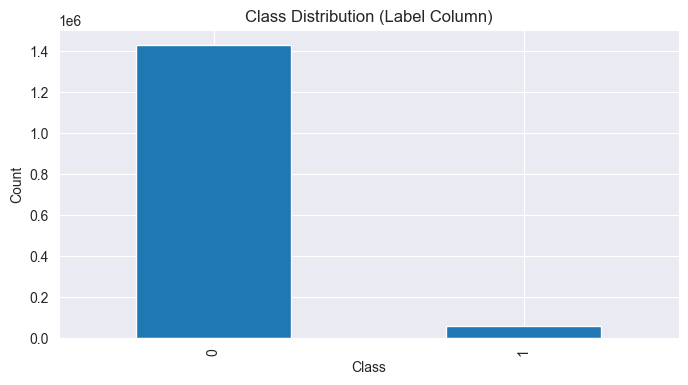

In [7]:
# Identify label column (if it's always last)
label_col = df.columns[-1]  # or explicitly label_col = "label"

# Ensure label is numeric
df[label_col] = pd.to_numeric(df[label_col], errors="coerce").fillna(0).astype(int)

# Create cleaned DataFrame (unsplit, unscaled)
df_cleaned = df.copy()

# Save cleaned file to ../data/
from pathlib import Path
DATA = Path("../data")
DATA.mkdir(parents=True, exist_ok=True)
df_cleaned.to_csv(DATA / "UNSW-NB15_cleaned.csv", index=False)
print("Saved:", DATA / "UNSW-NB15_cleaned.csv", "→", df_cleaned.shape)

# Optional: visualize label distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
df_cleaned[label_col].value_counts().plot(kind='bar')
plt.title('Class Distribution (Label Column)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()